# Global Holidays and Travel

#### Team Name: Anything Honestly
#### Team Members: 
- Daeren Kim Boon Hong
- Eugene Poon Wen Teng
- Jin Suxin
- Ng Chong Xuan
- Ong Wei Zheng, Julian
- Siah Jin Thau
#### Central Question: <i>How do holidays and regional differences affect air travel patterns over time?</i>

In [2]:
# Notebook Setup - Importing Modules
import calendar
import math
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

from kneed import KneeLocator
from scipy.stats import linregress
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import geodatasets
import geopandas as gpd
import pycountry_convert as pc

## Executive Summary

We were curious to explore how global holidays and regional differences influence air travel patterns over time. By combining data on international holidays and airline passenger volumes, we aimed to uncover how culture, geography, and economics shape when and where people travel. Using datasets compiled by Lai et al. (2020), we analyzed global mobility trends between 2010 and 2018 to understand how holidays and seasons affect travel behavior across different continents.

Our analysis is presented in three parts. First, we compared holiday frequency and traveller volume across regions to reveal how festive periods align with peaks in air travel. Secondly, we examined monthly travel patterns for each continent to identify seasonal rhythms such as summer travel surges in Europe or Lunar New Year peaks in Asia. Lastly, we studied how the ratio of domestic-to-international travellers has evolved from 2010 to 2018, reflecting the influence of globalization and regional economic growth. Through these analyses, we highlight how cultural calendars, economic development, and global connectivity drive the ebb and flow of human mobility worldwide.

## Introduction 

Every December, airports from New York to Tokyo burst into motion as millions of people fly around for the holidays. Weeks later, the skies over Asia swell again - this time with families reuniting for Lunar New Year. Holidays like these don’t just mark time on a calendar; they reshape global movement, driving waves of human mobility that ripple across countries and continents.

In this project, we explore how holidays and regional differences shape air travel patterns across the world. Drawing on two open-source datasets compiled by Lai et al. (2020), we combine information from **`global_holidays.csv`** and **`monthly_passengers.csv`** to uncover how culture, geography, and economics influence travel patterns. The **`global_holidays.csv`** dataset records the dates, names, and types of observances (such as public holidays and local celebrations), while the **`monthly_passengers.csv`** dataset provides monthly counts of total, domestic, and international flight passengers across 90 countries. Together, they allow us to examine how different factors influence global mobility and reveal how shared cultural rhythms translate into measurable patterns of worldwide movement.

By analyzing these datasets, we seek to answer the question: <i><u>How do holidays and regional differences affect air travel patterns over time?</u></i> Our exploration provides insights into seasonal and regional travel dynamics, offering a deeper understanding of how cultural rhythms and global connectivity influence the movement of people across the world.

### global_holidays.csv

| Variable | Class     | Description                     |
|-----------|-----------|---------------------------------|
| ADM_name  | character | Location name                   |
| ISO3      | character | 3-letter country code           |
| Date      | date      | Observance date                 |
| Name      | character | Observance name                 |
| Type      | character | Holiday/observance category     |


### monthly_passengers.csv

| Variable      | Class     | Description                              |
|----------------|-----------|------------------------------------------|
| ISO3           | character | 3-letter country code                   |
| Year           | integer   | Year of flights                         |
| Month          | integer   | Month of flights                        |
| Total          | double    | Total passengers (thousands)            |
| Domestic       | double    | Domestic passengers (thousands)         |
| International  | double    | International passengers (thousands)    |
| Total_OS       | double    | Total passengers from other sources     |


## Data Cleaning

In [3]:
# Functions for Importing Data

def import_data() -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Downloads data from tidytuesday
    Global Holidays Dataset:
      - https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-12-24/global_holidays.csv
    Monthly Passengers Dataset:
      - https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-12-24/monthly_passengers.csv
    """
    holidays_data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-12-24/global_holidays.csv")
    passengers_data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-12-24/monthly_passengers.csv")
    print("Imported: Holidays Data + Passengers Data")
    return holidays_data, passengers_data


In [4]:
# Helper Functions for Processing Data

def __convert_date_column_to_datetime_obj(data: pd.DataFrame) -> pd.DataFrame:
    data["Date"] = pd.to_datetime(
        data["Date"],
        format = "%Y-%m-%d"
    )
    print("Converted 'Date' column to datetime object")
    return data

def __drop_duplicate_rows(data: pd.DataFrame) -> pd.DataFrame:
    if data.duplicated().any():
        print(f"Dropped {data.duplicated().sum()} duplicate rows")
        data = data.drop_duplicates(ignore_index = True)
        return data
    print("No duplicate rows found")
    return data

def __check_long_holiday(data: pd.DataFrame) -> pd.DataFrame:
    """
    Add a 'Long Holiday' column to the holidays dataframe.
    A holiday is a part of a 'Long Holiday' if 
    it is part of 3 consecutive non-working days.
    """

    # Ensure Date is datetime
    data = data.copy()
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Get day of week (0 = Monday, 6 = Sunday)
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    
    # Create a dictionary of holiday dates by country
    holiday_dates_by_country = {}
    for country in data['ISO3'].unique():
        country_holidays = set(data[data['ISO3'] == country]['Date'])
        holiday_dates_by_country[country] = country_holidays
    
    # Initialize Long Holiday column
    data['Long Holiday'] = False
    
    data["Long Holiday"] = False
    for idx, row in data.iterrows():
        date = row['Date']
        country = row['ISO3']
        day_of_week = row['DayOfWeek']
        
        # Get holiday dates for this country
        country_holidays = holiday_dates_by_country[country]
        
        # Function to check if a date is a holiday in this country
        def is_holiday(check_date):
            return check_date in country_holidays
        
        # Monday: True if it's a holiday
        if day_of_week == 0:
            data.at[idx, "Long Holiday"] = True
        
        # Tuesday: True if Monday before is holiday OR (Wed AND Thu after are holidays)
        elif day_of_week == 1:
            monday = date - pd.Timedelta(days = 1)
            wednesday = date + pd.Timedelta(days = 1)
            thursday = date + pd.Timedelta(days = 2)
            
            data.at[idx, "Long Holiday"] = (is_holiday(monday) or 
                                          (is_holiday(wednesday) and is_holiday(thursday)))
        
        # Wednesday: True if Tuesday before AND Thursday after are holidays
        elif day_of_week == 2:
            tuesday = date - pd.Timedelta(days = 1)
            thursday = date + pd.Timedelta(days = 1)
            
            data.at[idx, "Long Holiday"] = (is_holiday(tuesday) and is_holiday(thursday))
        
        # Thursday: True if Friday after is holiday OR (Tue AND Wed before are holidays)
        elif day_of_week == 3:
            tuesday = date - pd.Timedelta(days = 2)
            wednesday = date - pd.Timedelta(days = 1)
            friday = date + pd.Timedelta(days = 1)
            
            data.at[idx, "Long Holiday"] = (is_holiday(friday) or 
                                          (is_holiday(tuesday) and is_holiday(wednesday)))
        
        # Friday: True if it's a holiday
        elif day_of_week == 4:
            data.at[idx, "Long Holiday"] = True
        
        # Saturday or Sunday: True if Friday before OR Monday after is a holiday
        elif day_of_week in [5, 6]:
            # Calculate Friday before and Monday after based on current day
            if day_of_week == 5:  # Saturday
                friday = date - pd.Timedelta(days = 1)
                monday = date + pd.Timedelta(days = 2)
            else:  # Sunday
                friday = date - pd.Timedelta(days = 2)
                monday = date + pd.Timedelta(days = 1)
            
            data.at[idx, "Long Holiday"] = (is_holiday(friday) or is_holiday(monday))
    
    # Drop helper column
    data = data.drop("DayOfWeek", axis = 1)

    print("Added 'Long Holiday' flag")
    
    return data

def __rename_infrequent_holiday_names(data: pd.DataFrame) -> pd.DataFrame:
    # Compute cumulative distribution
    vc = data["Name"].value_counts()
    cum_counts = vc.cumsum()
    cum_percent = cum_counts / cum_counts.iloc[-1] * 100

    # Find "knee" (elbow) point
    x = np.arange(len(vc))
    y = cum_percent.values

    knee = KneeLocator(x, y, curve = "concave", direction = "increasing")
    elbow_index = knee.knee  # index of the elbow
    elbow_value = vc.iloc[elbow_index] if elbow_index is not None else None

    # Plot cumulative curve with elbow
    plt.figure(figsize = (10, 6))
    plt.plot(x, y, label = "Cumulative %")
    if elbow_index is not None:
        plt.axvline(
            elbow_index, 
            color = "red", 
            linestyle = "--", 
            label = f"Elbow at {elbow_index} ({elbow_value} occurrences)")
    plt.title("Cumulative Distribution of Holiday Name Frequencies with Elbow Point")
    plt.xlabel("Number of unique holiday names (sorted)")
    plt.ylabel("Cumulative % of total occurrences")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Group based on elbow frequency threshold
    threshold = elbow_value
    data["Name"] = data["Name"].where(
        data["Name"].isin(vc[vc >= threshold].index),
        other = "Other"
    )

    print(f"Renamed infrequent holiday names with frequency threshold: {threshold}")

    return data

def __standardize_holiday_name(data: pd.DataFrame) -> pd.DataFrame:

    def __holiday_name_map(name: str) -> str:
        name = str(name).strip()

        holiday_mapping = {
            # Labor Day / May Day variations
            'Labor Day / May Day': 'Labor Day / May Day',
            'Labour Day': 'Labor Day / May Day',
            'May Day': 'Labor Day / May Day',
            'Labour Day/May Day': 'Labor Day / May Day',
            'Workers\' Day': 'Labor Day / May Day',
            
            # Mother's Day variations
            'Mother\'s Day': 'Mother\'s Day',
            'Mothers\' Day': 'Mother\'s Day',
            'Mothering Sunday': 'Mother\'s Day',
            
            # Father's Day variations
            'Father\'s Day': 'Father\'s Day',
            'Fathers\' Day': 'Father\'s Day',
            'Father?s Day': 'Father\'s Day',
            
            # Christmas variations
            'Christmas Day': 'Christmas Day',
            'Christmas': 'Christmas Day',
            'Christmas Day observed': 'Christmas Day',
            
            # New Year's Eve variations
            'New Year\'s Eve': 'New Year\'s Eve',
            'New Year?s Eve': 'New Year\'s Eve',
            
            # New Year's Day variations
            'New Year\'s Day': 'New Year\'s Day',
            'New Year': 'New Year\'s Day',
            'New Year\'s Day observed': 'New Year\'s Day',
            
            # Easter Sunday variations
            'Easter Sunday': 'Easter Sunday',
            'Easter': 'Easter Sunday',
            'Easter Day': 'Easter Sunday',
            
            # All Saints' Day variations
            'All Saints\' Day': 'All Saints\' Day',
            'All Saints Day': 'All Saints\' Day',
            
            # All Souls' Day variations
            'All Souls\' Day': 'All Souls\' Day',
            'All Soul\'s Day': 'All Souls\' Day',
            
            # St. Stephen's Day variations
            'St. Stephen\'s Day': 'St. Stephen\'s Day',
            'St Stephen\'s Day': 'St. Stephen\'s Day',
            
            # St. Patrick's Day variations
            'St. Patrick\'s Day': 'St. Patrick\'s Day',
            'St Patrick\'s Day': 'St. Patrick\'s Day',
            
            # St. George's Day variations
            'St. George\'s Day': 'St. George\'s Day',
            'St George\'s Day': 'St. George\'s Day',
            
            # Orthodox Easter Sunday variations
            'Orthodox Easter Day': 'Orthodox Easter Sunday',
            'Orthodox Easter Sunday': 'Orthodox Easter Sunday',
            'Easter Sunday (Orthodox)': 'Orthodox Easter Sunday',
            
            # Orthodox Easter Monday variations
            'Orthodox Easter Monday': 'Orthodox Easter Monday',
            'Easter Monday (Orthodox)': 'Orthodox Easter Monday',
            
            # Orthodox Good Friday variations
            'Orthodox Good Friday': 'Orthodox Good Friday',
            'Good Friday (Orthodox)': 'Orthodox Good Friday',
            
            # Orthodox Easter Saturday variations
            'Orthodox Easter Saturday': 'Orthodox Easter Saturday',
            'Easter Saturday (Orthodox)': 'Orthodox Easter Saturday',
            
            # Teachers' Day variations
            'Teachers\' Day': 'Teachers\' Day',
            'Teacher\'s Day': 'Teachers\' Day',
            'Teacher?s Day': 'Teachers\' Day',
            
            # Children's Day variations
            'Children\'s Day': 'Children\'s Day',
            'Children?s Day': 'Children\'s Day',
            'National Children\'s Day': 'Children\'s Day',
            
            # Chinese New Year variations
            'Chinese New Year': 'Chinese New Year',
            'Chinese Lunar New Year\'s Day': 'Chinese New Year',
            
            # Immaculate Conception variations
            'Feast of the Immaculate Conception': 'Immaculate Conception',
            'Immaculate Conception': 'Immaculate Conception',
            
            # Independence Day variations
            'Independence Day': 'Independence Day',
            'Independence Day observed': 'Independence Day',
            'Independence Day Holiday': 'Independence Day',
            'Independence Day holiday': 'Independence Day',
            'Day off for Independence Day': 'Independence Day',
            
            # Eid al-Fitr variations
            'Eid al-Fitr': 'Eid al-Fitr',
            'Eid al-Fitr Holiday': 'Eid al-Fitr',
            'Eid al-Fitr holiday': 'Eid al-Fitr',
            'Hari Raya Puasa': 'Eid al-Fitr',
            
            # Eid al-Adha variations
            'Eid al-Adha': 'Eid al-Adha',
            'Eid al-Adha Holiday': 'Eid al-Adha',
            'Eid al-Adha holiday': 'Eid al-Adha',
            'Eid al-Adha (Feast of Sacrifice)': 'Eid al-Adha',
            'Feast of the Sacrifice': 'Eid al-Adha',
            'Hari Raya Haji': 'Eid al-Adha',
            
            # Boxing Day variations
            'Boxing Day': 'Boxing Day',
            'Boxing Day observed': 'Boxing Day',
            
            # Second Day of Christmas variations
            'Second Day of Christmas': 'Second Day of Christmas',
            'Second day of Christmas': 'Second Day of Christmas',
            
            # Day after New Year's Day variations
            'Day after New Year\'s Day': 'Day after New Year\'s Day',
            'Day After New Year\'s Day': 'Day after New Year\'s Day',
            
            # April Fools' Day variations
            'April Fools': 'April Fools\' Day',
            'April Fool\'s Day': 'April Fools\' Day',
            
            # Constitution Day variations
            'Constitution Day': 'Constitution Day',
            'Constitution Day observed': 'Constitution Day',
            
            # Ramadan variations
            'Ramadan begins': 'Ramadan begins',
            'Ramadan Start': 'Ramadan begins',
            
            # The Prophet's Birthday variations
            'The Prophet Muhammad\'s Birthday': 'The Prophet\'s Birthday',
            'The Prophet\'s Birthday': 'The Prophet\'s Birthday',
            
            # Buddha's Birthday variations
            'Buddha\'s Birthday': 'Buddha\'s Birthday',
            'Buddha Purnima/Vesak': 'Buddha\'s Birthday',
            
            # National Heroes' Day variations
            'National Heroes Day': 'National Heroes\' Day',
            'Heroes\' Day': 'National Heroes\' Day',
            'National Heroes\' Day': 'National Heroes\' Day',
        }

        return holiday_mapping.get(name, name)

    data['Name'] = data['Name'].apply(__holiday_name_map)

    return data

def __verify_no_nas(data: pd.DataFrame) -> pd.DataFrame:
    if data.isnull().values.any():
        print("WARNING: Missing Values Detected!")
    else:
        print("No NA values in Dataset")
    return data

def __drop_passenger_rows_missing_all_info(data: pd.DataFrame) -> pd.DataFrame:
    before = len(data)
    data = data[
        ~(
            data["Total_OS"].isna() & 
            data["Total"].isna()
        )
    ].reset_index(drop = True)
    dropped = before - len(data)
    print(f"Dropped {dropped} rows, missing all passenger data (Total, Domestic, International, Total_OS)")
    return data

def __fill_total_with_os_total(data: pd.DataFrame) -> pd.DataFrame:
    mask = data["Total"].isna() & data["Total_OS"].notna()
    filled_count = mask.sum()
    data.loc[mask, "Total"] = data.loc[mask, "Total_OS"]
    print(f"Filled {filled_count} missing 'Total' values using 'Total_OS'")
    return data

def __drop_total_from_other_sources(data: pd.DataFrame) -> pd.DataFrame:
    data = data.drop("Total_OS", axis = 1)
    print("Dropped 'Total_OS' Column")
    return data

def __fill_in_domestic_where_needed(data: pd.DataFrame) -> pd.DataFrame:
    mask = (
        data["Total"].notna() &
        data["International"].notna() &
        (data["Total"] == data["International"])
    )
    if mask.any():
        data.loc[mask, "Domestic"] = 0
        print(f"Filled in {mask.sum()} Domestic values with 0")
        return data
    print("No Domestic data to fill in")
    return data

def __verify_missing_granular_data(data: pd.DataFrame) -> pd.DataFrame:
    missing_international = data["International"].isna()
    missing_domestic = data["Domestic"].isna()
    if any(missing_domestic != missing_international):
        print("WARNING: Mismatch of rows missing granular data")
    else:
        print(f"Verified matching of {missing_international.sum()} rows missing granular data")
    return data


In [5]:
# Function for Processing Holidays Data & Passengers Data

def process_holidays_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Processes Holidays Dataset
    Processing Steps:
      - Converts "Date" column to datetime object
      - Attempts to drop duplicate rows (13 Rows)
      - Flags long holidays (>=3 Consecutive Non-Working Days)
      - Rename infrequent holidays to "Other"
      - Standardizes remaining holiday names to fix duplicates and variations
      - Check for NA values (None)
    """
    
    print("Cleaning Holidays Data")
    print("==========================================")

    # Convert "Date" column to datetime object
    data = __convert_date_column_to_datetime_obj(data)

    # Attempt to drop duplicate rows
    data = __drop_duplicate_rows(data)

    # Add "Long Holiday" flag
    data = __check_long_holiday(data)

    # Rename infrequent holidays
    data = __rename_infrequent_holiday_names(data)

    # Standardize remaining holiday names
    data = __standardize_holiday_name(data)

    # Check for NA values
    data = __verify_no_nas(data)

    print("==========================================")
    print("Done Cleaning Holidays Data \n")

    return data

def process_passengers_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Processes Passengers Dataset
    Processing Steps:
      - Attempts to drop duplicate rows (0 Rows)
      - Drops rows where all passenger data is missing (5 Rows)
      - Fill in Total column with Total from other sources if Total is missing (3282 rows)
      - Drop 'Total_OS', Total from other sources 
      - Fill Domestic = 0 if Total and International are both not missing and have the same value (555 rows)
      - Verify that the rows missing domestic data are the same rows missing international data (3390 rows)
    """

    print("Cleaning Passengers Data")
    print("==========================================")

    # Attempt to drop duplicate rows
    data = __drop_duplicate_rows(data)

    # Drop rows where all passenger data is missing
    data = __drop_passenger_rows_missing_all_info(data)

    # Fill in Total column if needed
    data = __fill_total_with_os_total(data)

    # Drop "Total_OS" column
    data = __drop_total_from_other_sources(data)

    # Fill Domestic = 0 if Total and International are both not missing and have the same value
    data = __fill_in_domestic_where_needed(data)

    # Verify that the rows missing domestic data are the same rows missing international data
    data = __verify_missing_granular_data(data)

    print("==========================================")
    print("Done Cleaning Passengers Data")

    return data

def merge_dataframes(holidays_data: pd.DataFrame, passengers_data: pd.DataFrame) -> pd.DataFrame:
    holidays_data["Date"] = holidays_data["Date"].values.astype("datetime64[M]")
    passengers_data["Date"] = pd.to_datetime(passengers_data[["Year", "Month"]].assign(day = 1))
    passengers_data["Date"] = passengers_data["Date"].values.astype("datetime64[M]")
    merged = pd.merge(holidays_data, passengers_data, on = ["ISO3", "Date"], how = "inner")
    merged = merged.drop(columns = ["Year", "Month"], errors = "ignore")
    print("Successfully merged Holidays Data & Passengers Data")
    return merged

Imported: Holidays Data + Passengers Data
Cleaning Holidays Data
Converted 'Date' column to datetime object
Dropped 13 duplicate rows
Added 'Long Holiday' flag


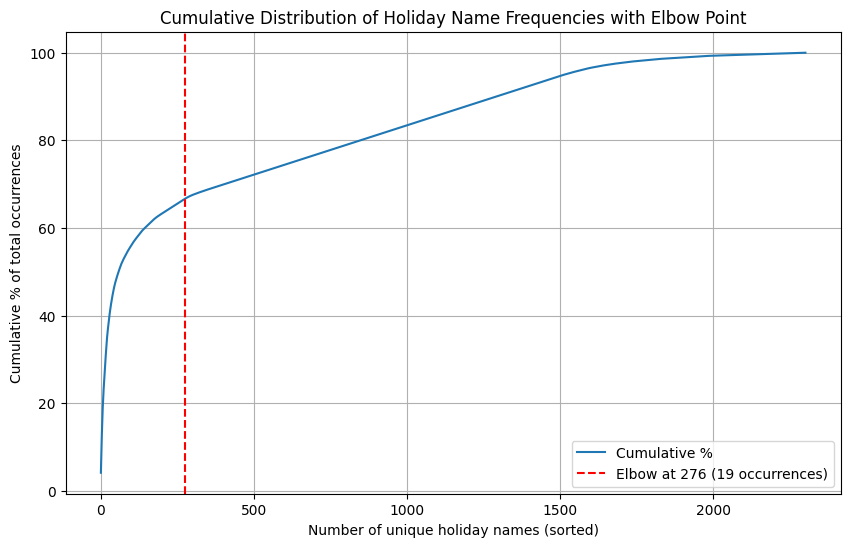

Renamed infrequent holiday names with frequency threshold: 19
No NA values in Dataset
Done Cleaning Holidays Data 

Cleaning Passengers Data
No duplicate rows found
Dropped 5 rows, missing all passenger data (Total, Domestic, International, Total_OS)
Filled 3282 missing 'Total' values using 'Total_OS'
Dropped 'Total_OS' Column
Filled in 555 Domestic values with 0
Verified matching of 3390 rows missing granular data
Done Cleaning Passengers Data


In [6]:
holidays_data, passengers_data = import_data()
clean_holidays_data = process_holidays_data(holidays_data)
clean_passengers_data = process_passengers_data(passengers_data)

In [7]:
clean_holidays_data

,ADM_name,ISO3,Date,Name,Type,Long Holiday
0,Aruba,ABW,2010-01-01,New Year's Day,Public holiday,True
1,Aruba,ABW,2010-01-25,Other,Public holiday,True
2,Aruba,ABW,2010-02-15,Carnival Monday,Public holiday,True
3,Aruba,ABW,2010-03-18,Other,Public holiday,False
4,Aruba,ABW,2010-04-02,Good Friday,Public holiday,True
...,...,...,...,...,...,...
44375,Palestine,PSE,2015-12-24,Prophet's Birthday,Public holiday,True
44376,Palestine,PSE,2016-12-12,Prophet's Birthday,Public holiday,True
44377,Palestine,PSE,2017-12-01,Prophet's Birthday,Public holiday,True
44378,Palestine,PSE,2018-11-21,Prophet's Birthday,Public holiday,False


In [8]:
clean_passengers_data

,ISO3,Year,Month,Total,Domestic,International
0,ALB,2010,1,117.350,NaN,NaN
1,ALB,2010,2,86.535,NaN,NaN
2,ALB,2010,3,103.795,NaN,NaN
3,ALB,2010,4,102.038,NaN,NaN
4,ALB,2010,5,109.037,NaN,NaN
...,...,...,...,...,...,...
7232,ZAF,2017,8,3425.617,NaN,NaN
7233,ZAF,2017,9,3454.075,NaN,NaN
7234,ZAF,2017,10,3678.780,NaN,NaN
7235,ZAF,2017,11,3482.341,NaN,NaN


In [9]:
data = merge_dataframes(clean_holidays_data, clean_passengers_data)
data

Successfully merged Holidays Data & Passengers Data


,ADM_name,ISO3,Date,Name,Type,Long Holiday,Total,Domestic,International
0,Albania,ALB,2010-02-01,Valentine's Day,Observance,False,86.535,NaN,NaN
1,Albania,ALB,2010-03-01,Mother's Day,Observance,True,103.795,NaN,NaN
2,Albania,ALB,2010-04-01,Good Friday,Observance,True,102.038,NaN,NaN
3,Albania,ALB,2010-04-01,Orthodox Good Friday,Observance,True,102.038,NaN,NaN
4,Albania,ALB,2010-04-01,Orthodox Easter Saturday,Observance,True,102.038,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15029,Bulgaria,BGR,2014-05-01,Other,Working day (replacement),False,511.137,14.695,496.442
15030,Bulgaria,BGR,2012-05-01,Other,Working day (replacement),False,438.227,18.534,419.693
15031,Bulgaria,BGR,2014-05-01,Other,Working day (replacement),False,511.137,14.695,496.442
15032,Bulgaria,BGR,2015-09-01,Other,Working day (replacement),False,921.961,16.846,905.115


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15034 entries, 0 to 15033
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype        
---  ------         --------------  -----        
 0   ADM_name       15034 non-null  object       
 1   ISO3           15034 non-null  object       
 2   Date           15034 non-null  datetime64[s]
 3   Name           15034 non-null  object       
 4   Type           15034 non-null  object       
 5   Long Holiday   15034 non-null  bool         
 6   Total          15034 non-null  float64      
 7   Domestic       8235 non-null   float64      
 8   International  8235 non-null   float64      
dtypes: bool(1), datetime64[s](1), float64(3), object(4)
memory usage: 954.4+ KB


### Data Cleaning Summary

This analysis processed two datasets from TidyTuesday: Global Holidays and Monthly Passengers data. The cleaning pipeline standardized both datasets and merged them for analysis of the relationship between holidays and air passenger traffic.

The holidays dataset underwent several transformations to ensure consistency and usability. After converting the date column to datetime objects, 13 duplicate rows were identified and removed. A key feature engineering step involved creating a "Long Holiday" flag to identify holidays that are part of three or more consecutive non-working days, using day-specific logic that considers weekends and adjacent holidays by country. To reduce noise from rare holidays, the elbow method identified a frequency threshold of 19 occurrences, and holidays appearing less frequently were relabeled as "Other". Holiday names were then standardized to consolidate variations such as "Labour Day" and "May Day" into a canonical "Labor Day / May Day", addressing over 40 different naming inconsistencies including apostrophe variations. The final dataset contained no missing values.

The passengers dataset required handling of missing data across multiple passenger metrics. After confirming no duplicate rows existed, 5 rows missing all passenger data were removed. The dataset contained 3,282 missing values in the Total column, which were filled using the Total_OS (Total from Other Sources) column before that column was dropped. For 555 rows where Total equaled International passengers, Domestic was set to zero, indicating international-only airports. A verification step confirmed that 3,390 rows had matching missingness patterns for both Domestic and International metrics.

The datasets were merged by converting daily holiday dates to monthly periods to match the passenger data granularity, then performing an inner join on country code and month-year. The final integrated dataset contains 15,034 records with 9 variables, including holiday attributes and passenger metrics. While Total passengers are available for all records, granular Domestic and International breakdowns are only available for 54.8% of the data, representing 8,235 rows. This cleaned dataset enables analysis of holiday impacts on air travel patterns across different countries and time periods.

## Data Visualization and Discussion

### Plot 1: Bivariate Choropleth Map: Log-Transformed and Min–Max Normalised Average Quarterly Holidays and Air Passengers in thousands per Country (2010–2019)

The bivariate choropleth maps presented below show the average number of holidays and the average number of air passengers (in thousands) per country for each quarter from 2010 to 2019. Bivariate choropleth mapping is a powerful visualisation method that enables us to examine the interplay between two related variables without the need for separate maps (Battersby, 2018). Together with the bivariate legend, this visualisation method allows us to directly visualise the relationship between holiday frequency and air travel intensity across different countries and quarters of the year.

In these maps, two variables are represented: (i) ```Avg_hols```, which indicates the average number of holidays in each country per quarter, and (ii) ```Avg_total```, which refers to the average number of air passengers in each country per quarter (in thousands). These variables cannot be directly used to create visualisations, as both are extremely right-skewed. This skewness can cause misinterpretation during analysis, as large outliers may obscure meaningful variations among smaller data values, leading to poor colour contrast in the plot. To overcome this issue, we applied log transformation to ```Avg_hols``` and ```Avg_total``` to reduce the impact of large values and make the data distribution more symmetric, while preserving the original distribution of the data (Traffine I/O, n.d.; Ismay & Kim, 2019). The transformed variables are referred to as ```Avg_hols_log``` and ```Avg_total_log```, respectively. 

After conducting the log transformation, we employed Min-Max normalisation to rescale the logarithmic data to a range between 0 and 1 inclusive. This step is crucial for converting the variables—```Avg_hols_log``` and ```Avg_total_log```—into values suitable for representing RGB colours while maintaining the original data distribution, similar to log transformation (Rabeya et al., 2025). Additionally, applying Min-Max normalisation after log transformation is important, as it is sensitive to outliers. If we had not log-transformed the data before normalisation, the majority of data values could be compressed into a small range, leading to poor colour contrast in the plot (Ismay & Kim, 2019). The Min-Max normalized versions of ```Avg_hols_log``` and ```Avg_total_log``` are referred to as ```hols_scaled``` and ```total_scaled```, respectively.

Thus, although the colours on the maps and bivariate legend are based on the log transformation and Min-Max normalisation of the original data values (```hols_scaled``` and ```total_scaled```), the axis labels in the bivariate legend have been replaced with the original data values from ```Avg_hols``` and ```Avg_total```, since the relative order of the data remains preserved.

In [11]:
# Load world shapefile
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

# Creating year and quarter columns
df = data.copy()
df["Year"] = df["Date"].dt.year
df["Quarter"] = df["Date"].dt.quarter #df["Quarter"] = df["Date"].dt.to_period("Q").dt.quarter  # New: Quarter (1-4)

# Average number of holidays per quarter over the years from 2010 to 2019: Avg_hols
df1 = df.groupby(["ISO3", "Quarter", "Year"]).agg(count=("Name", "count")).reset_index()
df1 = df1.groupby(["ISO3", "Quarter"]).agg(Avg_hols=("count", "mean")).reset_index()
merged_avg_quarter_hols = world[["ISO_A3", "geometry"]].merge(df1, left_on="ISO_A3", right_on="ISO3", how="left")
merged_avg_quarter_hols

# Average number of passengers per quarter over the years from 2010 to 2019: Avg_total
df2 = df.groupby(["ISO3", "Quarter", "Year"]).agg(Sum=("Total", "sum")).reset_index()
df2 = df2.groupby(["ISO3", "Quarter"]).agg(Avg_total=("Sum", "mean")).reset_index()
merged_avg_quarter_total = world[["ISO_A3", "geometry"]].merge(df2, left_on="ISO_A3", right_on="ISO3", how="left")
merged_avg_quarter_total

# Left outer join data between merged_avg_quarter_hols and merged_avg_quarter_total data
gdf = merged_avg_quarter_hols.merge(merged_avg_quarter_total[["ISO3", "Quarter", "Avg_total"]], 
on=["ISO3", "Quarter"], how="left"
)

# Natural log transformaton of columns Avg_hols and Avg_total due to high right skewness
gdf["Avg_total_log"] = np.log(gdf["Avg_total"])
gdf["Avg_hols_log"] = np.log(gdf["Avg_hols"])

# Min-max normalisation to get values from 0 to 1 so that we can use them to create RGB plots
gdf["total_scaled"] = (gdf["Avg_total_log"] - gdf["Avg_total_log"].min()) / (
    gdf["Avg_total_log"].max() - gdf["Avg_total_log"].min()
)
gdf["hols_scaled"] = (gdf["Avg_hols_log"] - gdf["Avg_hols_log"].min()) / (
    gdf["Avg_hols_log"].max() - gdf["Avg_hols_log"].min()
)

# Finalised data
gdf = gdf.sort_values("Quarter", ascending = True, na_position = "last")
gdf

,ISO_A3,geometry,ISO3,Quarter,Avg_hols,Avg_total,Avg_total_log,Avg_hols_log,total_scaled,hols_scaled
306,CAN,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025...",CAN,1.0,15.888889,73589.444444,11.206257,2.765620,0.663187,0.754314
8645,BEL,"POLYGON ((6.15666 50.80372, 6.04307 50.12805, ...",BEL,1.0,3.666667,6591.251778,8.793499,1.299283,0.437061,0.354375
8649,NLD,"POLYGON ((6.90514 53.48216, 7.09205 53.14404, ...",NLD,1.0,2.666667,11465.628000,9.347109,0.980829,0.488946,0.267518
5887,ISR,"POLYGON ((35.71992 32.70919, 35.54567 32.39399...",ISR,1.0,6.000000,7699.511250,8.948912,1.791759,0.451627,0.488696
8652,PRT,"POLYGON ((-9.03482 41.88057, -8.67195 42.13469...",PRT,1.0,2.555556,5790.855667,8.664035,0.938270,0.424928,0.255910
...,...,...,...,...,...,...,...,...,...,...
10689,SSD,"POLYGON ((30.83385 3.50917, 29.9535 4.1737, 29...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10690,SSD,"POLYGON ((30.83385 3.50917, 29.9535 4.1737, 29...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10691,SSD,"POLYGON ((30.83385 3.50917, 29.9535 4.1737, 29...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10692,SSD,"POLYGON ((30.83385 3.50917, 29.9535 4.1737, 29...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


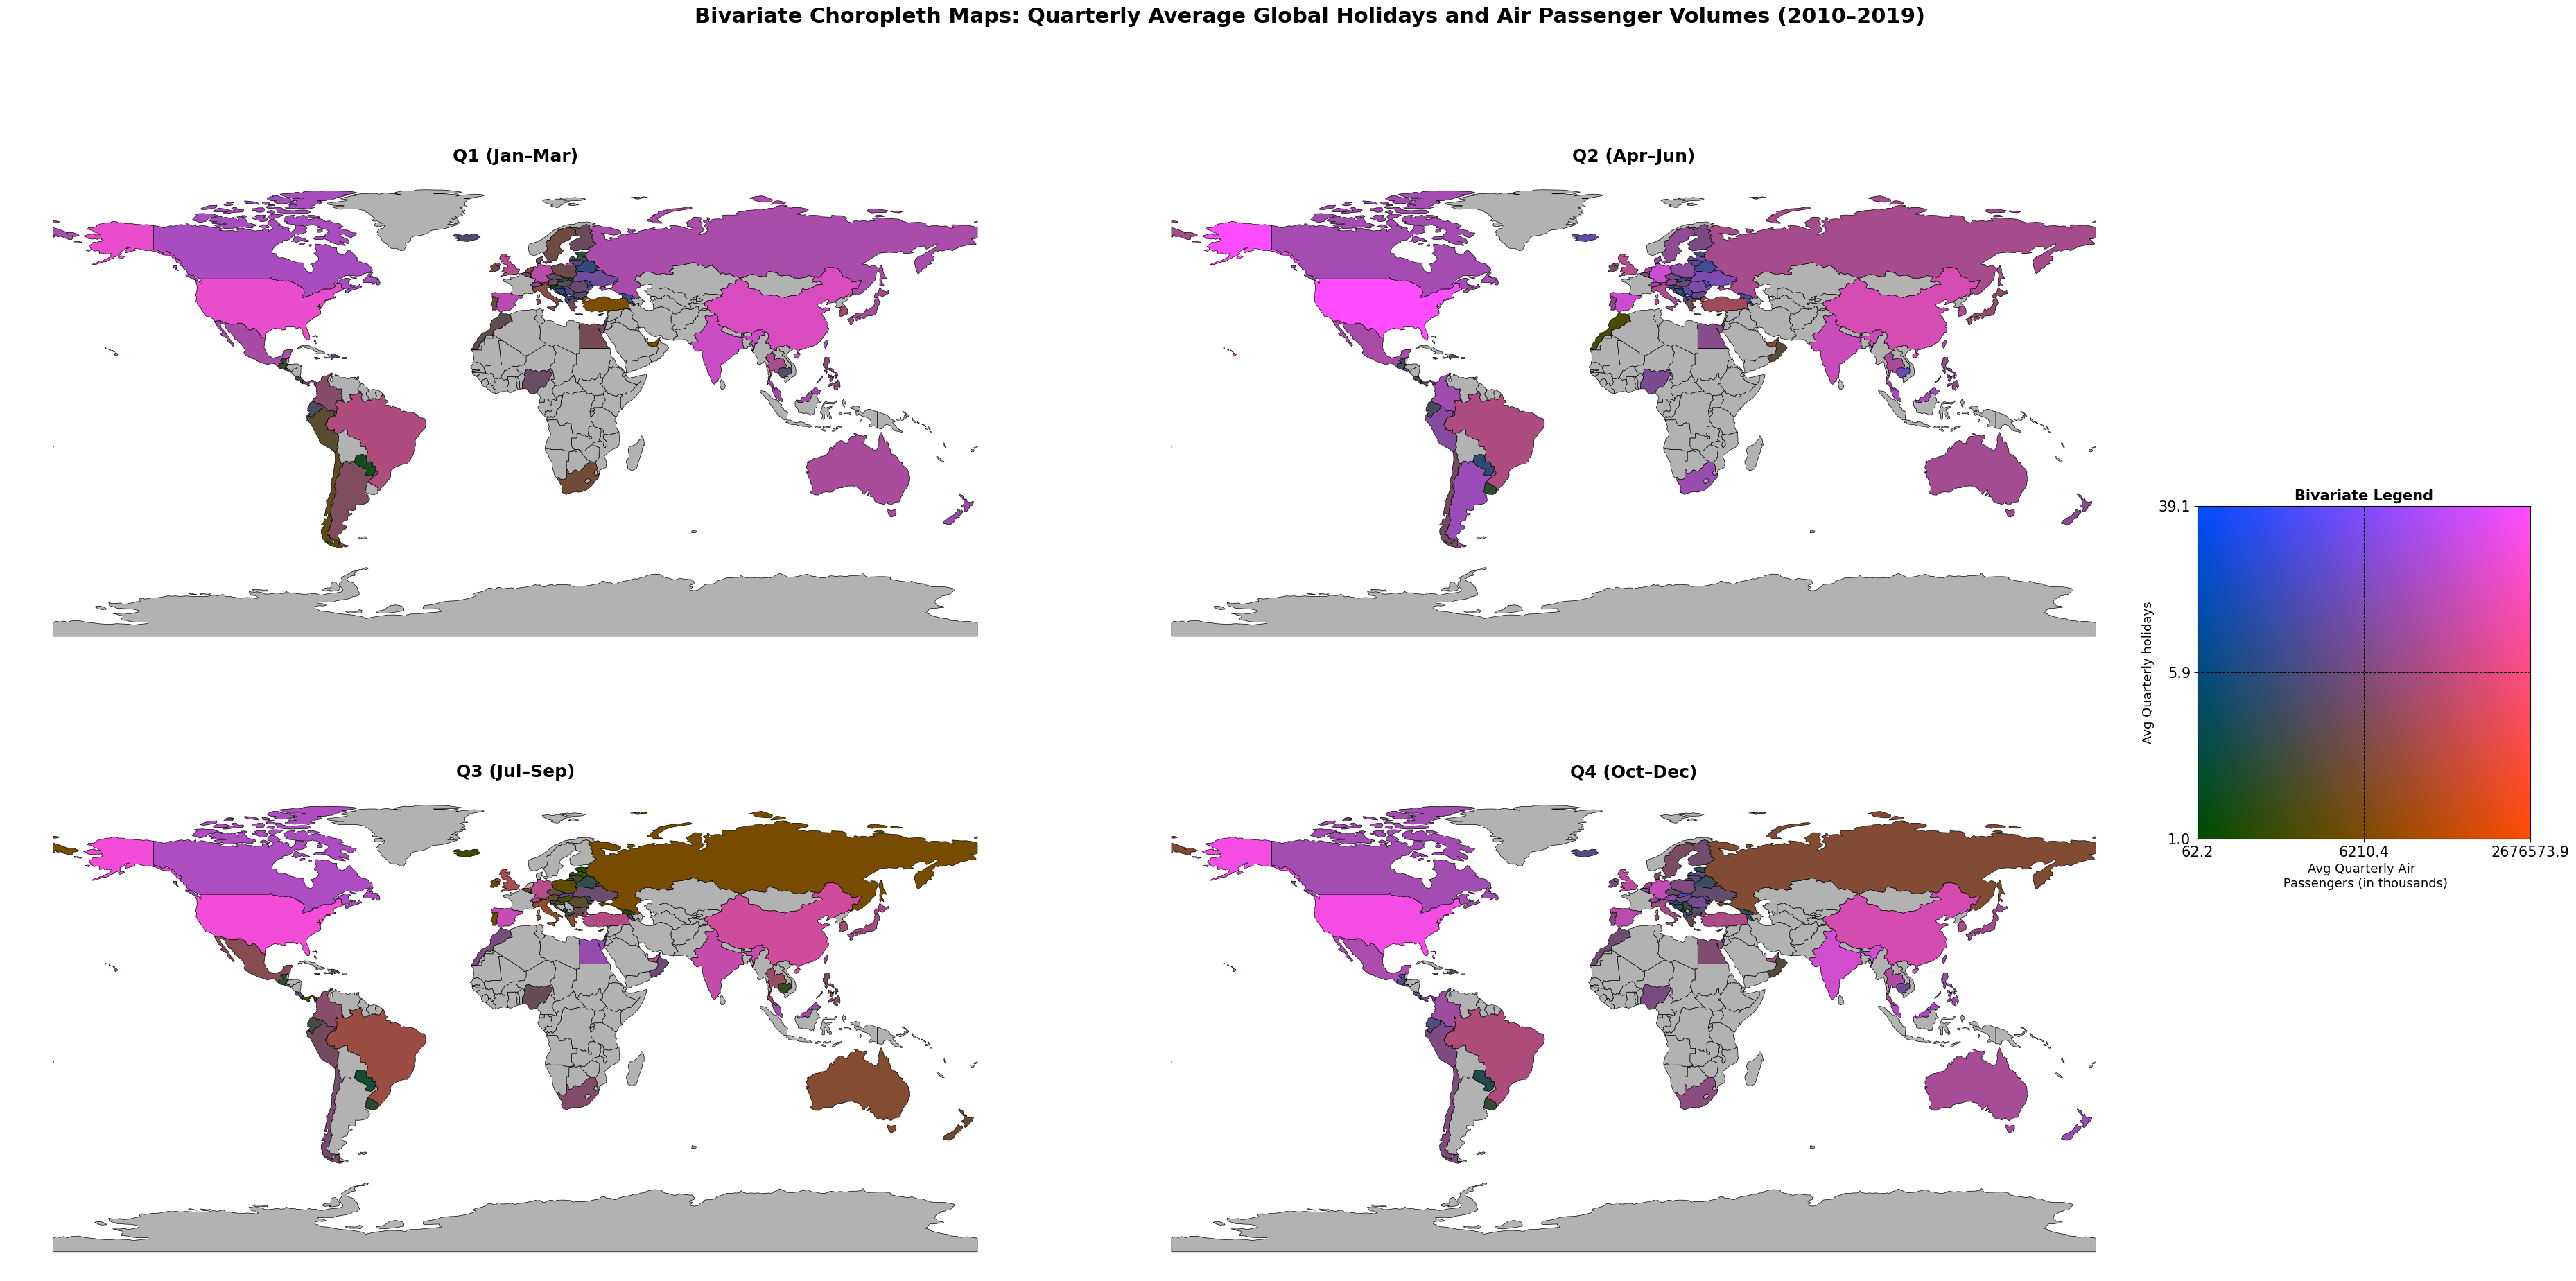

In [12]:
### Initialize an empty figure and add an axis ###
fig, axes = plt.subplots(2, 2, figsize=(40, 20))
plt.rcParams.update({"font.size": 15})

### This is used to create the bivarate legend ###

# Create bivarate colormap function
def bivariate_color(x, y):
    if np.isnan(x) and np.isnan(y): # This handles nan values
        return mcolors.to_hex((0.7, 0.7, 0.7))  # return grey for na values
    return mcolors.to_hex((x, 0.3, y))  # (R, G, B)

# Create the 2D color grid 
x = np.linspace(0, 1, 100)  # 100 realisations of possible scaled Avg_total between 0 and 1
y = np.linspace(0, 1, 100)  # 100 realisations of possible scaled Avg_hols between 0 and 1
X, Y = np.meshgrid(x, y) # Create a 2D array
Z = np.zeros((100, 100, 3)) # Create a 100x100 grid each containing 3 spots for RGB

# This creates all possible colors found in the bivariate legend, where we save the data in Z
for i in range(100):
    for j in range(100):
        Z[i, j, :] = (X[i,j], 0.3, Y[i,j])  # R = total, B = hols

# Create a box-shaped bivariate legend on the right side of the figure 
legend_ax = fig.add_axes([0.82, 0.20, 0.12, 0.60])
legend_ax.imshow(Z, origin="lower", extent=[0, 1, 0, 1])

# Labels for the bivariate legend
legend_ax.set_xlabel("Avg Quarterly Air \n Passengers (in thousands)", fontsize=13)
legend_ax.set_ylabel("Avg Quarterly holidays", fontsize=13)
legend_ax.set_title("Bivariate Legend", fontsize=15, fontweight="bold")

# Set and show the numeric ticks of both log averages: 0, 50, and 100 percentile 
legend_ax.set_xticks([0, 0.5, 1])
legend_ax.set_yticks([0,0.5, 1])
legend_ax.set_xticklabels([round(gdf['Avg_total'].min(),1), round(gdf['Avg_total'].median(),1), round(gdf['Avg_total'].max(),1)])
legend_ax.set_yticklabels([round(gdf['Avg_hols'].min(),1), round(gdf['Avg_hols'].median(),1), round(gdf['Avg_hols'].max(),1)])
legend_ax.grid(True, ls = "--", color = "black")

### This is used to create the 4 subplots: "Q1 (Jan–Mar)", "Q2 (Apr–Jun)", "Q3 (Jul–Sep)", "Q4 (Oct–Dec)"" ###

# Quarters list

quarters = [1, 2, 3, 4]
quarter_names = ["Q1 (Jan–Mar)", "Q2 (Apr–Jun)", "Q3 (Jul–Sep)", "Q4 (Oct–Dec)"]

# Creating the subplots

for quarter, name, ax in zip(quarters, quarter_names, axes.flatten()):
    
    # This merges the world data with gdf data of a specific month so that all countries can be plotted regardless of whether they have the data for that quarter
    now = world[["ISO_A3", "geometry"]].merge(
        gdf[gdf["Quarter"] == quarter],
        left_on="ISO_A3",
        right_on="ISO3",
        how="left"
    ).drop(["ISO_A3_y", "geometry_y", "ISO3"], axis=1).rename(columns={"geometry_x": "geometry"})

    # Create color column by associating different scaled values with different colors found in the bivariate map
    now["color"] = now.apply(lambda r: bivariate_color(r["total_scaled"], r["hols_scaled"]), axis=1)

    # This plots the data based on colors 
    now.plot(
        color = now["color"], # bivarate colors
        edgecolor="black", # country border colors
        linewidth=0.5, # width of country borders
        ax=ax # specifies which subplot to use
    )

    # Turn off the axis ticks
    ax.axis("off")

    # Set title of subplot
    ax.set_title(name, fontsize=18, fontweight="bold")

# Create a title for the whole figure
plt.suptitle(
    "Bivariate Choropleth Maps: Quarterly Average Global Holidays and Air Passenger Volumes (2010–2019)",
    fontsize=22, fontweight="bold"
)

# Adjust the subplots without using tight_layout()
plt.subplots_adjust(left=0.03, right=0.80, top=0.88, bottom=0.05, hspace=0.15, wspace=0.1)

#Show the data visualisation
plt.show()

The global distribution of air travel reveals distinct patterns driven by economics, geography, and tourism. The United States stands out with a consistently bright purple color, reflecting year-round high passenger volumes from its large domestic market, dense flight network, and significant international traffic. This contrasts with Canada's darker purple, which, despite a similar number of holidays, indicates lower absolute traffic, underscoring the impact of population size and network density. Meanwhile, countries like Russia and Turkey show their own remarkable patterns. Russia's color darkens significantly in the third and fourth quarters, signaling a major seasonal travel increase despite low number of public holidays. Turkey, similarly bright, likely sustains its high passenger volumes through a powerful combination of a major geographical hub (Istanbul) and a thriving year-round tourism industry.

In Europe, the drivers of high air traffic are diverse. Germany and the United Kingdom appear bright primarily due to their roles as major continental aviation hubs, with high volumes of transit and business traffic. Spain's brightness is a classic example of a destination economy, fueled by a massive, continuous influx of international tourists. Notably, France's data is missing, which is a significant gap as its inclusion would likely show a similar profile to the UK and Germany, given the importance of Paris's airports. Australia, New Zealand, Mexico and Brazil both turn brown in their third quarter, pattern of these countries aligns with inbound tourism from summer break of north hemispehere and domestic school holidays, which is not considered as public holidays.

Finally, some regions demonstrate how travel has become a constant economic engine. China, Japan and South Korea
 maintain a high purple baseline year-round, with only slightly brighter spikes during the Lunar New Year and National Day holidays. This suggests a powerful commercial travel sector that smooths out extreme seasonal peaks. Conversely, Southeast Asian nations generally show muted seasonal color shifts, indicating stable travel patterns, though the Philippines exhibits a slight dip in the third quarter, potentially linked to monsoon seasonality. Together, these patterns illustrate that there is no single story for global air travel, but rather a combination of interconnected local realities.

### Plot 2: Line Plot of Total Passenger vs Time Across Continents

Analyzing patterns between regional air travel and regional or seasonal holiday calendars over 12 months across the years will further our investigation on the correlation between air travel and holidays over time.  By visualizing the total number of air passengers per region each month over the years with a line plot give a clearer picture on fluctuations of air travel by month. By
 displaying temporal changes of values with slopes,
 line graphs allow us to perceive trends and other patterns easily. Therefore, they are often taken as the best choice for visualizing
 time series data (Wang et al., 2018). In our case, any commonalities in air traffic and regional holidays for the region would pinpoint that travel is positively correlated with leisure time. 

8 line graphs will be plotted with months on the X-axis and total number of air passengers each month on the Y-axis. The 7 lines in each graph are colored by the 7 major continent as to help us understand regional air travel patterns across the globe. To prepare the our data, we standardized the country names stored in the rows and mapped each country to their respective continent. Countries that do not belong to one of the 7 major continents are stored as 'Others'. Following that, we separated the 'Date' column into two columns, 'Month and 'Year', grouped the data by 'Month', 'Year' and 'Continent', and summed the the total number of passengers per region each month. Due to the lack of data for 2019 and 2018, where data for air passengers were only recorded for China in 2019 and a lack of air passenger data for other continents especially for Asia in 2018, we decided to exclude data from these two years in our visualization to avoid misinterpretations that leads to inaccuracies when analyzing the trends of air travel for each month. 

In [13]:
df_plot2= data.copy()

# Clean country names
def clean_country(name):
    if pd.isna(name):
        return name
    name = name.strip()
    name = name.replace('-', ' ')
    name = name.title()

    manual = {
        "Us": "United States",
        "Uk": "United Kingdom",
        "Czech": "Czechia",                 
        "Bosnia": "Bosnia and Herzegovina",
        "Kosovo": "Kosovo",                 
    }
    return manual.get(name, name)

df_plot2['ADM_name'] = df_plot2['ADM_name'].apply(clean_country)

# Map each country to their respective continent
country_plot2=df_plot2['ADM_name']

def country_to_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continents = {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "SA": "South America",
            "OC": "Oceania",
            "AN": "Antarctica"
        }
        return continents.get(continent_code, "Other")
    except:
        return "Other"

cleaned_country_plot2 = [clean_country(c) for c in country_plot2]
continent_map = {country: country_to_continent(country) for country in cleaned_country_plot2}

df_plot2['Continent'] = df_plot2['ADM_name'].apply(
    lambda x: continent_map.get(clean_country(x), "Other") if pd.notna(x) else x
)


In [14]:
# Clean data for plotting
# Separate Date column into Month and Year
# Filter out data in 2018 and 2019
df_plot2["Month"] = df_plot2["Date"].dt.month
df_plot2["Year"] = df_plot2["Date"].dt.strftime("%Y")
df_plot2=df_plot2[['Continent','ADM_name','ISO3','Name','Year','Month','Total']]
df_plot2 = df_plot2[~df_plot2['Year'].isin(['2018', '2019'])] 
df_plot2

,Continent,ADM_name,ISO3,Name,Year,Month,Total
0,Europe,Albania,ALB,Valentine's Day,2010,2,86.535
1,Europe,Albania,ALB,Mother's Day,2010,3,103.795
2,Europe,Albania,ALB,Good Friday,2010,4,102.038
3,Europe,Albania,ALB,Orthodox Good Friday,2010,4,102.038
4,Europe,Albania,ALB,Orthodox Easter Saturday,2010,4,102.038
...,...,...,...,...,...,...,...
15029,Europe,Bulgaria,BGR,Other,2014,5,511.137
15030,Europe,Bulgaria,BGR,Other,2012,5,438.227
15031,Europe,Bulgaria,BGR,Other,2014,5,511.137
15032,Europe,Bulgaria,BGR,Other,2015,9,921.961


In [15]:
# Group by Year, Month and Continent
# Sum total air passengers for each month 

df_plot2_agg = (
    df_plot2.groupby(['Year', 'Month', 'Continent'], as_index=False)['Total']
      .sum()
)
df_plot2_agg


,Year,Month,Continent,Total
0,2010,1,Africa,2047.916
1,2010,1,Asia,70462.646
2,2010,1,Europe,192133.799
3,2010,1,North America,182368.021
4,2010,1,Oceania,13136.000
...,...,...,...,...
623,2017,12,Europe,545218.512
624,2017,12,North America,754500.288
625,2017,12,Oceania,61507.635
626,2017,12,Other,391.325


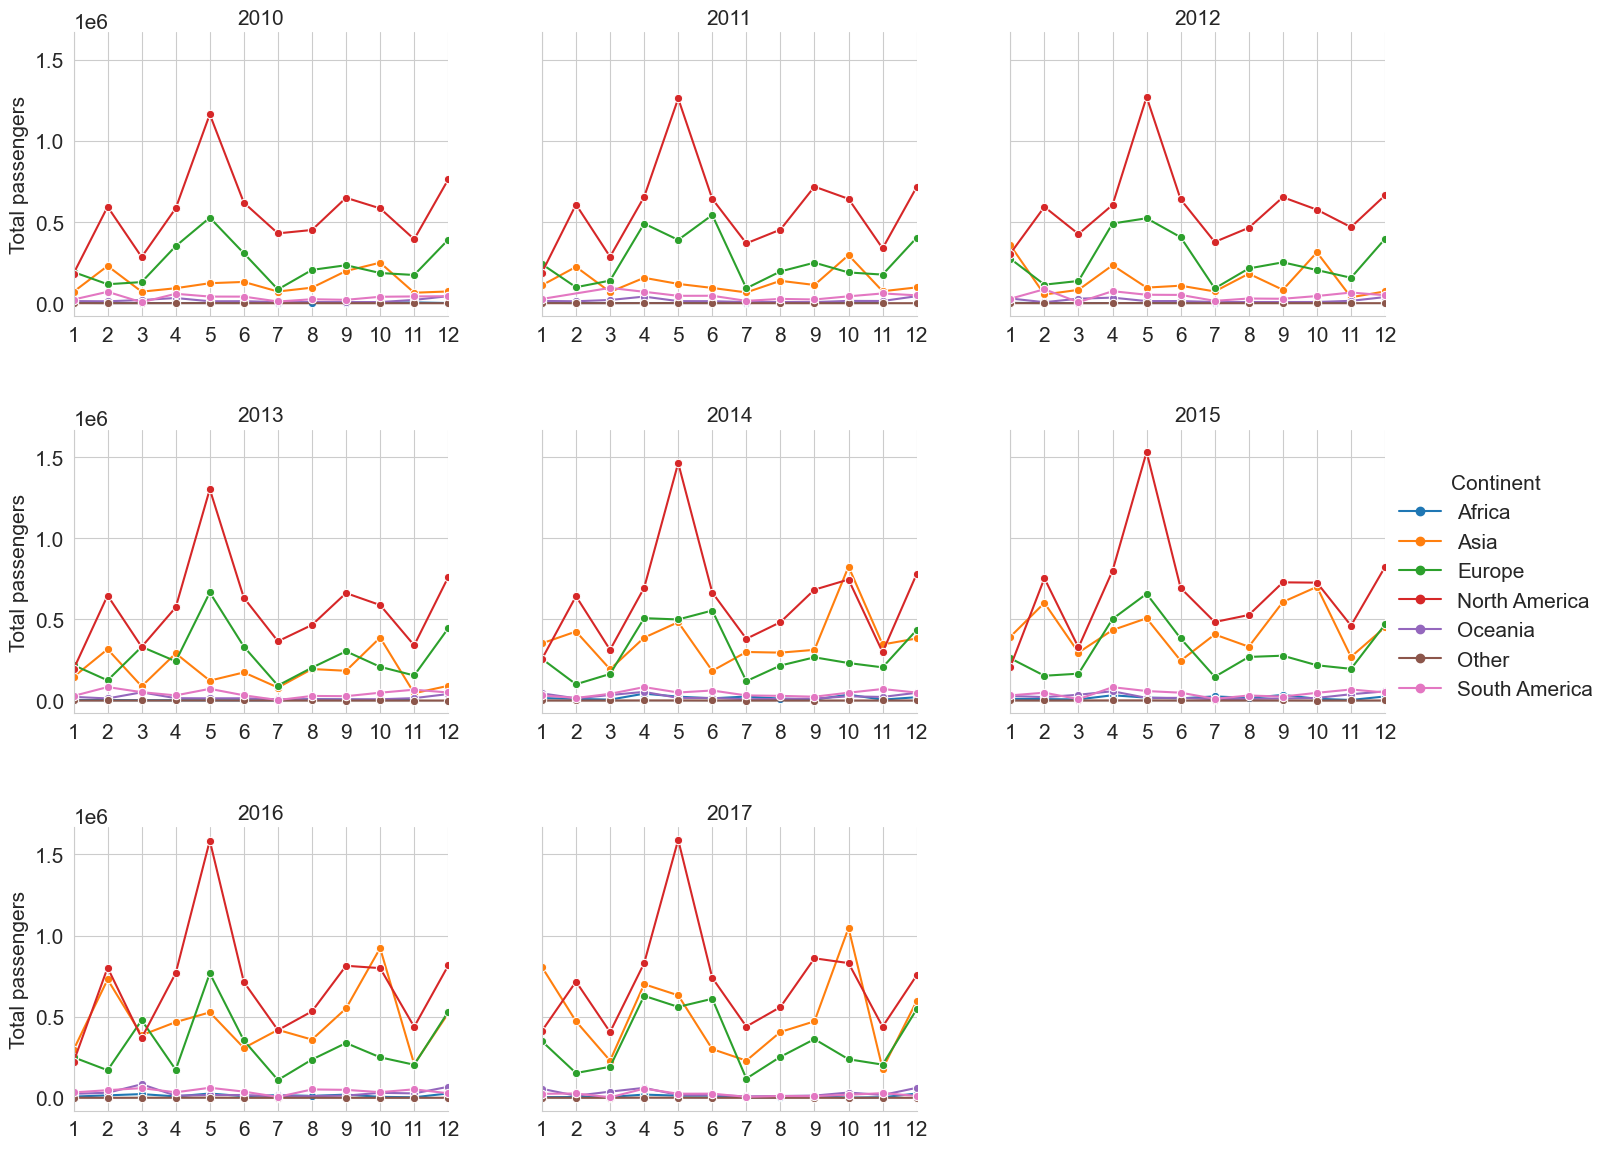

In [16]:
# Plot line graph: Total Passengers by Month for each Year
sns.set_style("whitegrid")
g = sns.relplot(
    data=df_plot2_agg,
    x='Month',
    y='Total',
    hue='Continent',
    col='Year',
    kind='line',
    marker='o',
    col_wrap=3,
    height=4.0,
    aspect=1.2
)

g.set_axis_labels(" ", "Total passengers")
g.set_titles("{col_name}")

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True)   
    ax.set_xticks(range(1, 13))        
    ax.set_xlim(1, 12)                 

plt.subplots_adjust(wspace=0.25, hspace=0.4)
plt.show()

The graphs show monthly air passenger trends across continents from 2010 to 2018. Using these line graphs, we aim to understand how each continent’s travelling patterns differ with month and their potential correlations with regional holidays. A clear seasonal pattern appears each year for almost all regions, highlighted by repeated yearly peaks for each region in specific months. North America consistently records the highest number of passengers owing to their strong global and domestic aviation market. This observation aligns with the high ratio of domestic air travelers to international ones in North America that is seen in our third visualization. Number of air passengers in North America peaks sharply around May, coinciding with summer vacation and Memorial Day holidays, when leisure travel typically surges. 

Asia and Europe follow similar trends but with smaller magnitudes. Air passengers in Asia often peak from either January or February and in October, possibly due to major regional holidays such as Lunar New Year and Golden Week, while Europe’s travel activity rises in the mid-year months (July and August), aligning with summer vacation when many Europeans take extended vacations. Africa, Oceania, and South America maintain relatively low and stable passenger volumes throughout the year, with slight peaks from February to April and from October to December. This may be attributed to structure of school terms in these regions, as peaks coincide with school holidays. Across the nine-year period, the seasonal cycles remain consistent, indicating a stable annual rhythm in global air travel. 

Generally, stronger correlation between total air passengers and regional holidays is observed in North America, Asia and Europe than in Africa, Oceania and South America. Differences in scale of aviation market and costs of air travel can impact regional air traffic flow. In this case, rather than holidays, high operation costs (IATA, 2025) and low connectivity (ALG Global, 2025) are possible substantiations for lower traffic flow in Africa, Oceania and South America. Moreover, there is a noticeable upward trend in Asia’s passenger volume after 2013, suggesting growing demand and connectivity within the region. Therefore indicating that air passenger trends are not solely influence by regional holidays, but economic growth, stability of a region and its connectivity as well. Overall, the data highlight strong seasonality and regional differences in travel intensity, which displays a strong link between air travel activity and global holiday calendars, underscoring how cultural and national holiday periods significantly shape passenger movements. 

### Plot 3: Bubble Plot of Domestic-to-International Flight Passenger Ratio Across Continent

For the 3rd plot, we wanted to explore and see how the domestic and international flights ratio has changed throughout the years, and if certain regions are more inclined to domestic travels, while others are more inclined to international travels. After removing null values for domestic and international travellers, most continents were preserved in the dataset, except for South America, which had insufficient data and was therefore excluded from the analysis. We then grouped the data by year and continent, and calculated the ratio of between the total domestic to total international flights for each continent and year. We represented our findings using a bubble plot, where the size indicates the total number of flights for that continent and year (with labels for larger bubbles), and the color indicates the ratio of domestic to international flights.

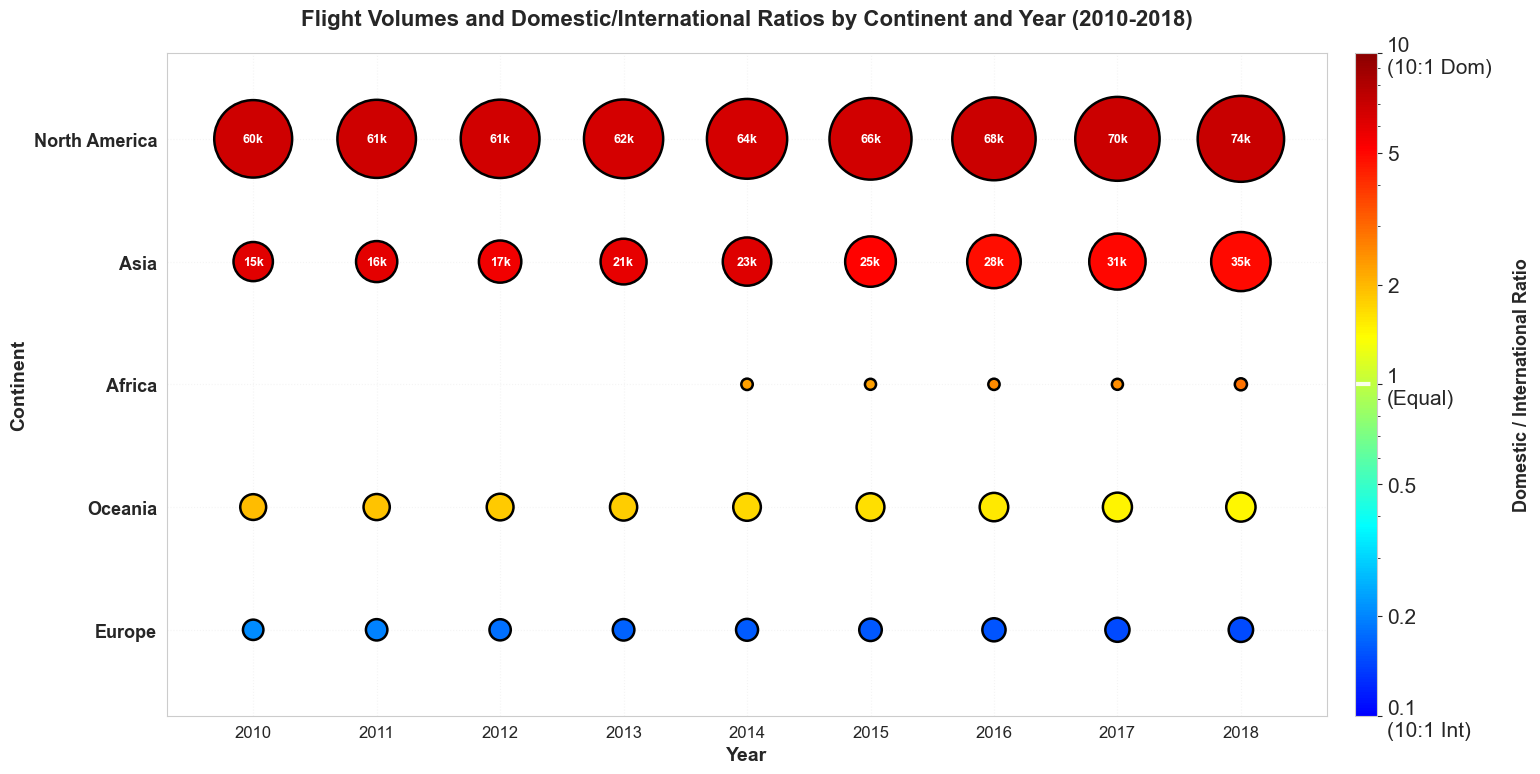

In [17]:
df_plot3 = data.copy()

continent_map = {
    # Oceania
    "Australia": "Oceania",
    # Europe
    "Austria": "Europe",
    "Belgium": "Europe",
    "Bulgaria": "Europe",
    "Cyprus": "Europe",
    "Czech": "Europe",
    "Germany": "Europe",
    "Denmark": "Europe",
    "Spain": "Europe",
    "Estonia": "Europe",
    "Finland": "Europe",
    "France": "Europe",
    "Uk": "Europe",
    "Greece": "Europe",
    "Croatia": "Europe",
    "Ireland": "Europe",
    "Iceland": "Europe",
    "Italy": "Europe",
    "Lithuania": "Europe",
    "Luxembourg": "Europe",
    "Latvia": "Europe",
    "Malta": "Europe",
    "Netherlands": "Europe",
    "Norway": "Europe",
    "Poland": "Europe",
    "Portugal": "Europe",
    "Romania": "Europe",
    "Slovakia": "Europe",
    "Slovenia": "Europe",
    "Sweden": "Europe",
    "Switzerland": "Europe",
    "Hungary": "Europe",
    # Africa
    "Nigeria": "Africa",
    # Asia
    "China": "Asia",
    "Thailand": "Asia",
    # North America
    "Us": "North America",
}

# Remove rows where both Domestic and International are NA
df_plot3 = df_plot3.dropna(subset=['Domestic', 'International'], how='all')

# Map continents
df_plot3['Continent'] = df_plot3['ADM_name'].apply(
    lambda x: continent_map.get(x, "Other") if pd.notna(x) else x
)

# Extract year from Date
df_plot3['Year'] = pd.to_datetime(df_plot3['Date']).dt.year
df_plot3 = df_plot3[(df_plot3['Year'] >= 2010) & (df_plot3['Year'] <= 2018)]

# Aggregate by Continent and Year (mean)
continent_year_summary = (
    df_plot3.groupby(['Continent', 'Year'])[['Domestic','International']]
    .mean()
    .reset_index()
)

continent_year_summary['Domestic_to_International'] = (
    continent_year_summary['Domestic'] / continent_year_summary['International']
)

# Step 5: Ensure all continents appear for all years
all_continents = continent_year_summary['Continent'].unique()
all_years = continent_year_summary['Year'].unique()
all_combinations = pd.MultiIndex.from_product([all_continents, all_years], 
                                              names=['Continent', 'Year'])
continent_year_summary = (continent_year_summary.set_index(['Continent','Year'])
                         .reindex(all_combinations)
                         .fillna(0)
                         .reset_index())

# After creating continent_year_summary and filtering to 2010-2018
plt.figure(figsize=(16, 8))

# Define continents and their order (top to bottom)
continents = ['North America', 'Asia', 'Africa', 'Oceania', 'Europe']
continent_positions = {cont: i for i, cont in enumerate(continents)}

# Get all years
years = sorted(continent_year_summary['Year'].unique())

# Calculate total flights and ratio
continent_year_summary['Total_Flights'] = (
    continent_year_summary['Domestic'] + continent_year_summary['International']
)
continent_year_summary['Domestic_to_International_Ratio'] = (
    continent_year_summary['Domestic'] / continent_year_summary['International']
)

# Normalize bubble sizes
max_flights = continent_year_summary['Total_Flights'].max()

# Vibrant Blue -> Yellow -> Red
colors = ['#0000ff', '#0080ff', '#00ffff', '#80ff80', '#ffff00', 
          '#ff8000', '#ff0000', '#8b0000']

n_bins = 256  # More bins = smoother gradient
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Set the normalization (log scale)
from matplotlib.colors import LogNorm
vmin = 0.1  # Very international-heavy
vmax = 10   # Very domestic-heavy
norm = LogNorm(vmin=vmin, vmax=vmax)

# Create the plot
for _, row in continent_year_summary.iterrows():
    if row['Continent'] not in continents or row['Total_Flights'] == 0:
        continue
    
    year = row['Year']
    continent = row['Continent']
    y_pos = continent_positions[continent]
    
    # Calculate bubble radius
    radius = 0.35 * np.sqrt(row['Total_Flights'] / max_flights)
    
    # Get color based on ratio
    ratio = row['Domestic_to_International_Ratio']
    ratio_clipped = np.clip(ratio, vmin, vmax)
    circle_color = cmap(norm(ratio_clipped))
    
    # Draw circle
    circle = mpatches.Circle(
        (year, y_pos), 
        radius,
        facecolor=circle_color,
        edgecolor='black',
        linewidth=1.8,
        alpha=1.0,  # Full opacity for stronger colors
        zorder=2
    )
    plt.gca().add_patch(circle)
    
    # Add text label with total flights
    if radius > 0.15:
        # Choose text color based on background brightness
        # Use white text for dark backgrounds, black for light
        brightness = np.mean(circle_color[:3])
        text_color = 'white' if brightness < 0.5 else 'black'
        
        plt.text(
            year, y_pos, 
            f"{int(row['Total_Flights']/1000)}k", 
            ha='center', va='center',
            fontsize=9, 
            weight='bold',
            color=text_color,
            zorder=3
        )
    # else:
    #     brightness = np.mean(circle_color[:3])
    #     text_color = 'white' if brightness < 0.5 else 'black'
        
    #     plt.text(
    #         year, y_pos - 0.18, 
    #         f"{int(row['Total_Flights']/1000)}k", 
    #         ha='center', va='center',
    #         fontsize=9, 
    #         weight='bold',
    #         color=text_color,
    #         zorder=3
    #     )

# Set up axes
plt.yticks(range(len(continents)), continents, fontsize=13, weight='bold')
plt.xticks(years, [str(y) for y in years], fontsize=12)
plt.xlabel('Year', fontsize=14, weight='bold')
plt.ylabel('Continent', fontsize=14, weight='bold')
plt.title('Flight Volumes and Domestic/International Ratios by Continent and Year (2010-2018)', 
          fontsize=16, weight='bold', pad=20)

# Set axis limits
plt.xlim(years[0] - 0.7, years[-1] + 0.7)
plt.ylim(-0.7, len(continents) - 0.3)

# Add colorbar with better formatting
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02, aspect=30)
cbar.set_label('Domestic / International Ratio', fontsize=13, weight='bold', labelpad=15)

# Customize colorbar ticks
cbar.set_ticks([0.1, 0.2, 0.5, 1, 2, 5, 10])
cbar.set_ticklabels(['0.1\n(10:1 Int)', '0.2', '0.5', '1\n(Equal)', '2', '5', '10\n(10:1 Dom)'])

# Add reference line at ratio = 1
cbar.ax.axhline(1, color='white', linewidth=3, linestyle='--', alpha=0.9)

# Add grid
plt.grid(True, alpha=0.2, linestyle=':', axis='both', zorder=0)

# Invert y-axis
plt.gca().invert_yaxis()
plt.gca().set_aspect('auto')

plt.tight_layout()
plt.show()

Continents such as North America, Asia, Oceania, and Africa exhibit consistently higher domestic-to-international flight passenger ratios, as indicated by their bubble colors corresponding to values above 1. This trend can be attributed to each region’s vast geographic scale and dispersed population distribution, where large cities and urban centers in countries like the USA, China, India, and Australia are far apart and requires substantial domestic air travel, as it may not be convenient to do so by trains or buses. Strong local economies and air transportation networks also boost domestic travel, as people often fly within large countries for work, school, or to visit friends and family in other cities. In contrast, Europe stands out as an exception, maintaining a much lower ratio over the same period. This is likely caused by the continent’s compact geography, coupled with border-free travel through the Schengen Area, facilitating international trips as easily as domestic ones (European Parliament, 2025).

From 2010 to 2018, the total air passengers increased across most continents. For instance, North America grew from 60k to 74k and Asia grew from 15k to 35k. These increases signify economic growth, showing how air travel are becoming more accessible. Moreover, the evolution of flight ratios across the different regions reveals several distinct patterns. To begin with, North America and Europe maintained stable ratios, with not much change in colour, reflecting stable aviation markets with proportional growth in both domestic and international sectors. Meanwhile, Asia’s domestic-to-international ratio has declined, as observed by the colour change. Upon further investigation, it was found that it was driven by a rapid rise in international travel—spurred by expanding tourism, increasing cross-border business activity, and enhanced global connectivity (Wang et al., 2019). Oceania's ratio follows a similar but more moderate downward trend. Conversely, Africa displays a slight increase across the years, as seen by 2018 having a much darker shade of orange as compared to the other years, suggesting a growing domestic travel market as more people fly within their own countries (The Economic Times, 2018).

Overall, these patterns shows how changing flight ratios mirror broader economic growth, globalization trends, and the evolving dynamics of regional aviation markets.

## Summary

Our investigation set out to understand how holdiays and regional differences shape global air travel patterns, and the evidence acorss our three visualisations point to a consistent relationship. However, even though holidays may play a significant role in driving seasonal surges in regional air travel, they are insufficient in explaing global air travel patterns alone. 

The line graph indicate that holiday calendars are crucial factors in directing the flow of air traffic in regions around the globe. Regions like Asia, Europe and North America reflect peaks in air passenger flow during school holidays and festive seasons like Christmas and Lunar New Year. 

However, holidays alone cannot account for all regional patterns. At the same time, the line graph and bubble plot together show that regions like Africa, Oceania and South America exihibit muted seasonal variation, likely reflecting smaller aviation markets, higher travel costs and lower connectivity which potentially contrains air travel during holiday periods. THe domestic-international flight ratios further emphasize that geography and mode of interconnection within a region shape travel patterns. Large, dispersed regions like North America, Asia and Oceania rely more heavily on air when travelling domestically, while Europe's compact geography and well-developed domestic land transport system will lead to an aviation market that is more reliant on the international flight market. Lastly, the bivariate choropleth maps echoes that countries with frequent holidays paired with dense flight networks, strategic geographic location or a strong tourism economy often sustain higher air traffic volumes, as reflected in how countries like the United States, China, Turkey and Spain display persistently high levels of air traffic throughout the year. 

Overall, the visualisations demonstrate the holidays amplify regional travel patterns rather than determining them outright. Regions with strong avaition markets, high connectivity and large domestic networks are more responsive to holiday-driven air travel surges, while others reflect lesser fluctuation due to various limitations. Therfore, this report shows that global air travel is shaped by the interplay of holidays and regional differences in terms of culture, geography, economy and interconnectivity.


## Team Contribution


Plot 1: Ng Chong Xuan, Ong Wei Zheng, Julian

Plot 2: Eugene Poon Wen Teng, Jin Suxin

Plot 3: Daeren Kim Boon Hong, Siah Jin Thau

## References

1. ALG Global. (2025, January 14). Diagnosis of air connectivity in Latin America and its comparison with the European market. https://alg-global.com/blog/aviation/diagnosis-air-connectivity-latin-america-and-its-comparison-european-market

2. Battersby, S. (2018, March 1). How to make effective bivariate choropleth maps with Tableau. Tableau. https://www.tableau.com/blog/how-make-effective-bivariate-choropleth-maps-tableau-83121 

3. European Parliament. (n.d.). Schengen: A guide to the European border-free zone. https://www.europarl.europa.eu/topics/en/article/20190612STO54307/schengen-a-guide-to-the-european-border-free-zone

4. International Air Transport Association. (2025, July 31). Cost disadvantage of African airlines. https://www.iata.org/en/iata-repository/publications/economic-reports/cost-disadvantage-of-african-airlines/

5. Ismay, C., & Kim, A. Y. (2019). Chapter 12 Thinking with data. In Statistical inference via data science (Ver. 0.5.0). https://moderndive.github.io/moderndive_labs/static/previous_versions/v0.5.0/12-thinking-with-data.html 

6. Lai, S., Sorichetta, A., Steele, J., Ruktanonchai, C. W., Cunningham, A. D., Rogers, G., Koper, P., Woods, D., Bondarenko, M., Ruktanonchai, N. W., Shi, W., & Tatem, A. J. (2022). Global holiday datasets for understanding seasonal human mobility and population dynamics. Scientific Data, 9(1), 17. https://doi.org/10.1038/s41597-022-01120-z 

7. Rabeya, R. A., Hoon, N., Kim, H.-C., & Choi, H. K. (2025). Quality assessment of color normalization method by similarity index metrics: A comparative study for histopathology images. KSII Transactions on Internet and Information Systems, 19(5), 1667–1684. https://doi.org/10.3837/tiis.2025.05.014 

8. The Economic Times. (2018, December 18). Africa records 60% increase in domestic air travel. https://theeconomictimes.com.ng/2018/12/18/africa-records-60-increase-in-domestic-air-travels/ 

9. Traffine I/O. (n.d.). Normalization and standardization. https://io.traffine.com/en/articles/normalization-and-standardization 

10. Wang, J., Yang, H., & Wang, H. (2019). The evolution of China’s international aviation markets from a policy perspective on air passenger flows. Sustainability, 11(13), 3566. https://www.researchgate.net/publication/334103828_The_Evolution_of_China's_International_Aviation_Markets_from_a_Policy_Perspective_on_Air_Passenger_Flows

11. Wang, Y., Han, F., Zhu, L., Deussen, O., & Chen, B. (2018). Line Graph or Scatter Plot? Automatic Selection of Methods for Visualizing Trends in Time Series. IEEE Transactions on Visualization and Computer Graphics, 24(2), 1141–1154. https://graphics.uni-konstanz.de/publikationen/Wang2018LineGraphScatter/